#### Please Note: All the results after the Visualization Section are used in the Paper

In [1]:
import os
import sys
from os import listdir
from os.path import isfile, join
import IPython.display as ipd
import librosa 
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wav
import numpy as np
from timeit import default_timer as timer

In [2]:
filename ="UrbanSound8K/audio/fold1/7383-3-0-0.wav"

In [3]:
ipd.Audio(filename)

In [4]:
def extract_Chroma_stftandMFCC(filename):
    audio,sample_rate=librosa.load(filename, res_type='kaiser_fast')
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate,n_chroma=50).T,axis=0)
    mfccs=np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate , n_mfcc=50).T,axis=0)
    
    return chroma_stft, mfccs

In [5]:
start_time=timer()
a=extract_Chroma_stftandMFCC(filename)
end_time=timer()
print('Time to extract MFCC from one file: {:.3f}sec'.format((end_time-start_time)/60))

Time to extract MFCC from one file: 0.110sec


In [6]:
metadata= pd.read_csv("UrbanSound8k/metadata/UrbanSound8k.csv")
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
fold_list = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']

In [8]:
stacked_features = []
exceptions=0

start_time = timer()
for i in range(10):
    # get file names
    mypath = 'UrbanSound8K/audio/'+ fold_list[i] + '/'
    files = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
    
    for fn in files:
        try: # extract features
            mfccs = extract_Chroma_stftandMFCC(fn)
            features=np.reshape((mfccs),(20,5))
            
        except: # else exception (.ds_store files are part of mac file systems)
            print(fn)
            exceptions += 1
            continue
            
        l_row = metadata.loc[metadata['slice_file_name']==fn.split('/')[-1]].values.tolist()
        label = l_row[0][-1]
        fold = i+1
    
        stacked_features.append([features, features.shape, label, fold])
        
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

C:\Users\pc\Anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


UrbanSound8K/audio/fold1/.DS_Store


C:\Users\pc\Anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
C:\Users\pc\Anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\pc\Anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
C:\Users\pc\Anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


UrbanSound8K/audio/fold2/.DS_Store
UrbanSound8K/audio/fold3/.DS_Store
UrbanSound8K/audio/fold4/.DS_Store
UrbanSound8K/audio/fold5/.DS_Store
UrbanSound8K/audio/fold6/.DS_Store
UrbanSound8K/audio/fold7/.DS_Store
UrbanSound8K/audio/fold8/.DS_Store
UrbanSound8K/audio/fold9/.DS_Store
UrbanSound8K/audio/fold10/.DS_Store
Exceptions:  10
time taken: 27.0 minutes 46.8 seconds
None
Finished feature extraction from all folder


In [9]:
cols=["Feature_Values", "Matrix_Shape", "Label", "Folder_No"]
feature_metadata=pd.DataFrame(data=stacked_features, columns=cols)
feature_metadata.head()

,Feature_Values,Matrix_Shape,Label,Folder_No
0,"[[0.43009543, 0.42641523, 0.42061862, 0.430975...","(20, 5)",dog_bark,1
1,"[[0.35211265, 0.34623802, 0.32027006, 0.302557...","(20, 5)",dog_bark,1
2,"[[0.40203726, 0.41237363, 0.4372927, 0.4695518...","(20, 5)",dog_bark,1
3,"[[0.15579388, 0.15788382, 0.15425776, 0.168307...","(20, 5)",dog_bark,1
4,"[[0.58354944, 0.58172417, 0.582746, 0.54908836...","(20, 5)",gun_shot,1


In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


X = np.array(feature_metadata.Feature_Values.tolist())
y = np.array(feature_metadata.Label.tolist())


le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [11]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=42)

In [12]:
x_train = np.reshape(x_train, (6985, 20, 5, 1))
x_test = np.reshape(x_test, (1747, 20, 5, 1))

In [13]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, yy.shape)

(6985, 20, 5, 1) (1747, 20, 5, 1) (6985, 10) (1747, 10) (8732, 10)


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, LSTM, TimeDistributed, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import np_utils
from sklearn import metrics

In [15]:
import tensorflow as tf

In [16]:
# Checkpoint to save the best weights for Softmax
checkpoint_filepath = "C:/Users/pc/Desktop/Journal/Best Weights/MFCC_STFT/copy-model.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
input = Input(shape=(20, 5, 1))
#label = Input(shape=(10,))

x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding="Same")(input)
x = MaxPooling2D(padding="Same")(x)
x = Conv2D(128, kernel_size=(5, 5), activation='relu', padding="Same")(x)
x = MaxPooling2D(padding="Same")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

output = Dense(10, activation="softmax")(x)

model = Model(input, output)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_model=model.fit(x_train, y_train,
          batch_size=50,
          epochs=300,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[model_checkpoint_callback]
        )

Epoch 1/300
140/140 [==============================] - 14s 97ms/step - loss: 2.1743 - accuracy: 0.1901 - val_loss: 1.9118 - val_accuracy: 0.2954
Epoch 2/300
140/140 [==============================] - 11s 78ms/step - loss: 1.9469 - accuracy: 0.2596 - val_loss: 1.7528 - val_accuracy: 0.3612
Epoch 3/300
140/140 [==============================] - 8s 60ms/step - loss: 1.8202 - accuracy: 0.3277 - val_loss: 1.5276 - val_accuracy: 0.4505
Epoch 4/300
140/140 [==============================] - 8s 58ms/step - loss: 1.6764 - accuracy: 0.3863 - val_loss: 1.5035 - val_accuracy: 0.4522
Epoch 5/300
140/140 [==============================] - 8s 57ms/step - loss: 1.5255 - accuracy: 0.4600 - val_loss: 1.3410 - val_accuracy: 0.5489
Epoch 6/300
140/140 [==============================] - 10s 71ms/step - loss: 1.3918 - accuracy: 0.5168 - val_loss: 1.2406 - val_accuracy: 0.5764
Epoch 7/300
140/140 [==============================] - 9s 62ms/step - loss: 1.2822 - accuracy: 0.5576 - val_loss: 1.2587 - val_accura

140/140 [==============================] - 10s 72ms/step - loss: 0.1766 - accuracy: 0.9417 - val_loss: 0.2337 - val_accuracy: 0.9256
Epoch 114/300
140/140 [==============================] - 10s 71ms/step - loss: 0.1778 - accuracy: 0.9435 - val_loss: 0.2005 - val_accuracy: 0.9353
Epoch 115/300
140/140 [==============================] - 10s 69ms/step - loss: 0.1825 - accuracy: 0.9383 - val_loss: 0.2203 - val_accuracy: 0.9342
Epoch 116/300
140/140 [==============================] - 11s 75ms/step - loss: 0.1751 - accuracy: 0.9437 - val_loss: 0.2227 - val_accuracy: 0.9325
Epoch 117/300
140/140 [==============================] - 10s 70ms/step - loss: 0.1818 - accuracy: 0.9436 - val_loss: 0.2469 - val_accuracy: 0.9227
Epoch 118/300
140/140 [==============================] - 9s 68ms/step - loss: 0.1784 - accuracy: 0.9397 - val_loss: 0.1931 - val_accuracy: 0.9376
Epoch 119/300
140/140 [==============================] - 8s 59ms/step - loss: 0.1711 - accuracy: 0.9446 - val_loss: 0.2087 - val_accu

Epoch 169/300
140/140 [==============================] - 9s 68ms/step - loss: 0.1508 - accuracy: 0.9529 - val_loss: 0.2234 - val_accuracy: 0.9342
Epoch 170/300
140/140 [==============================] - 10s 71ms/step - loss: 0.1468 - accuracy: 0.9508 - val_loss: 0.2850 - val_accuracy: 0.9170
Epoch 171/300
140/140 [==============================] - 12s 87ms/step - loss: 0.1427 - accuracy: 0.9553 - val_loss: 0.2073 - val_accuracy: 0.9416
Epoch 172/300
140/140 [==============================] - 11s 80ms/step - loss: 0.1176 - accuracy: 0.9619 - val_loss: 0.2605 - val_accuracy: 0.9319
Epoch 173/300
140/140 [==============================] - 13s 94ms/step - loss: 0.1299 - accuracy: 0.9583 - val_loss: 0.2236 - val_accuracy: 0.9296
Epoch 174/300
140/140 [==============================] - 10s 70ms/step - loss: 0.1136 - accuracy: 0.9613 - val_loss: 0.2098 - val_accuracy: 0.9302
Epoch 175/300
140/140 [==============================] - 10s 68ms/step - loss: 0.1177 - accuracy: 0.9623 - val_loss: 0.

Epoch 225/300
140/140 [==============================] - 10s 71ms/step - loss: 0.1093 - accuracy: 0.9635 - val_loss: 0.2006 - val_accuracy: 0.9445
Epoch 226/300
140/140 [==============================] - 10s 70ms/step - loss: 0.0943 - accuracy: 0.9685 - val_loss: 0.2258 - val_accuracy: 0.9405
Epoch 227/300
140/140 [==============================] - 9s 62ms/step - loss: 0.1053 - accuracy: 0.9655 - val_loss: 0.2202 - val_accuracy: 0.9342
Epoch 228/300
140/140 [==============================] - 10s 71ms/step - loss: 0.1446 - accuracy: 0.9562 - val_loss: 0.2199 - val_accuracy: 0.9313
Epoch 229/300
140/140 [==============================] - 9s 65ms/step - loss: 0.0984 - accuracy: 0.9688 - val_loss: 0.2230 - val_accuracy: 0.9382
Epoch 230/300
140/140 [==============================] - 9s 63ms/step - loss: 0.1219 - accuracy: 0.9628 - val_loss: 0.2191 - val_accuracy: 0.9325
Epoch 231/300
140/140 [==============================] - 9s 63ms/step - loss: 0.1244 - accuracy: 0.9588 - val_loss: 0.223

140/140 [==============================] - 11s 79ms/step - loss: 0.0923 - accuracy: 0.9718 - val_loss: 0.2283 - val_accuracy: 0.9393
Epoch 282/300
140/140 [==============================] - 10s 69ms/step - loss: 0.0924 - accuracy: 0.9719 - val_loss: 0.2759 - val_accuracy: 0.9336
Epoch 283/300
140/140 [==============================] - 10s 70ms/step - loss: 0.0968 - accuracy: 0.9669 - val_loss: 0.1988 - val_accuracy: 0.9399
Epoch 284/300
140/140 [==============================] - 9s 62ms/step - loss: 0.1164 - accuracy: 0.9621 - val_loss: 0.1956 - val_accuracy: 0.9405
Epoch 285/300
140/140 [==============================] - 9s 67ms/step - loss: 0.1055 - accuracy: 0.9665 - val_loss: 0.1868 - val_accuracy: 0.9439
Epoch 286/300
140/140 [==============================] - 10s 73ms/step - loss: 0.0824 - accuracy: 0.9749 - val_loss: 0.1833 - val_accuracy: 0.9485
Epoch 287/300
140/140 [==============================] - 10s 72ms/step - loss: 0.0843 - accuracy: 0.9734 - val_loss: 0.1917 - val_accu

In [18]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy {:.3f}%".format(train_score[1]*100))
test_score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy {:.3f}%".format(test_score[1]*100))

Training Accuracy 99.585%
Testing Accuracy 93.703%


### ArcFace Model

In [144]:
# Checkpoint to save the best weights for ArcFace
checkpoint_filepath = "C:/Users/pc/Desktop/Journal/Best Weights/MFCC_STFT/copy-arc.hdf5"
Arc_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [145]:
%run utils.ipynb

In [146]:
input = Input(shape=(20, 5, 1))
label = Input(shape=(10,))

x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding="Same")(input)
x = MaxPooling2D(padding="Same")(x)
x = Conv2D(128, kernel_size=(5, 5), activation='relu', padding="Same")(x)
x = MaxPooling2D(padding="Same")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = ArcFace(n_classes=10)([x, label])
output = Dense(10, activation="softmax")(x)

model_arc = Model([input, label], output)

model_arc.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_arc=model_arc.fit([x_train, y_train],
          y_train,
          batch_size=50,
          epochs=300,
          verbose=1,
          validation_data=([x_test, y_test], y_test),
          callbacks=[Arc_checkpoint_callback]
        )

Epoch 1/300
140/140 [==============================] - 13s 89ms/step - loss: 2.1926 - accuracy: 0.2348 - val_loss: 2.0918 - val_accuracy: 0.2524
Epoch 2/300
140/140 [==============================] - 11s 76ms/step - loss: 2.0435 - accuracy: 0.3280 - val_loss: 2.1103 - val_accuracy: 0.2685
Epoch 3/300
140/140 [==============================] - 11s 76ms/step - loss: 1.9265 - accuracy: 0.3857 - val_loss: 1.8694 - val_accuracy: 0.3927
Epoch 4/300
140/140 [==============================] - 10s 75ms/step - loss: 1.8237 - accuracy: 0.4029 - val_loss: 1.7822 - val_accuracy: 0.3961
Epoch 5/300
140/140 [==============================] - 10s 72ms/step - loss: 1.7437 - accuracy: 0.4206 - val_loss: 1.7815 - val_accuracy: 0.3881
Epoch 6/300
140/140 [==============================] - 10s 73ms/step - loss: 1.6740 - accuracy: 0.4295 - val_loss: 1.6674 - val_accuracy: 0.4482
Epoch 7/300
140/140 [==============================] - 10s 74ms/step - loss: 1.6211 - accuracy: 0.4402 - val_loss: 1.5797 - val_ac

140/140 [==============================] - 9s 62ms/step - loss: 0.2222 - accuracy: 0.9632 - val_loss: 0.2244 - val_accuracy: 0.9594
Epoch 114/300
140/140 [==============================] - 9s 64ms/step - loss: 0.2019 - accuracy: 0.9678 - val_loss: 0.2078 - val_accuracy: 0.9628
Epoch 115/300
140/140 [==============================] - 9s 61ms/step - loss: 0.1986 - accuracy: 0.9701 - val_loss: 0.2369 - val_accuracy: 0.9485
Epoch 116/300
140/140 [==============================] - 9s 62ms/step - loss: 0.2019 - accuracy: 0.9655 - val_loss: 0.2004 - val_accuracy: 0.9634
Epoch 117/300
140/140 [==============================] - 9s 63ms/step - loss: 0.1866 - accuracy: 0.9696 - val_loss: 0.2167 - val_accuracy: 0.9616
Epoch 118/300
140/140 [==============================] - 9s 63ms/step - loss: 0.1821 - accuracy: 0.9727 - val_loss: 0.2053 - val_accuracy: 0.9576
Epoch 119/300
140/140 [==============================] - 9s 66ms/step - loss: 0.1831 - accuracy: 0.9708 - val_loss: 0.2017 - val_accuracy:

140/140 [==============================] - 11s 76ms/step - loss: 0.0584 - accuracy: 0.9930 - val_loss: 0.0876 - val_accuracy: 0.9817
Epoch 170/300
140/140 [==============================] - 10s 72ms/step - loss: 0.0672 - accuracy: 0.9891 - val_loss: 0.0885 - val_accuracy: 0.9805
Epoch 171/300
140/140 [==============================] - 11s 80ms/step - loss: 0.0725 - accuracy: 0.9874 - val_loss: 0.1063 - val_accuracy: 0.9771
Epoch 172/300
140/140 [==============================] - 11s 77ms/step - loss: 0.0662 - accuracy: 0.9885 - val_loss: 0.0924 - val_accuracy: 0.9788
Epoch 173/300
140/140 [==============================] - 10s 73ms/step - loss: 0.0709 - accuracy: 0.9880 - val_loss: 0.0838 - val_accuracy: 0.9828
Epoch 174/300
140/140 [==============================] - 11s 78ms/step - loss: 0.0658 - accuracy: 0.9898 - val_loss: 0.0724 - val_accuracy: 0.9863
Epoch 175/300
140/140 [==============================] - 10s 72ms/step - loss: 0.0582 - accuracy: 0.9916 - val_loss: 0.0745 - val_ac

Epoch 225/300
140/140 [==============================] - 10s 68ms/step - loss: 0.0351 - accuracy: 0.9937 - val_loss: 0.0459 - val_accuracy: 0.9891
Epoch 226/300
140/140 [==============================] - 10s 73ms/step - loss: 0.0281 - accuracy: 0.9960 - val_loss: 0.0478 - val_accuracy: 0.9874
Epoch 227/300
140/140 [==============================] - 10s 71ms/step - loss: 0.0247 - accuracy: 0.9961 - val_loss: 0.0477 - val_accuracy: 0.9897
Epoch 228/300
140/140 [==============================] - 10s 72ms/step - loss: 0.0333 - accuracy: 0.9937 - val_loss: 0.0551 - val_accuracy: 0.9857
Epoch 229/300
140/140 [==============================] - 10s 70ms/step - loss: 0.0329 - accuracy: 0.9941 - val_loss: 0.0615 - val_accuracy: 0.9851
Epoch 230/300
140/140 [==============================] - 10s 68ms/step - loss: 0.0288 - accuracy: 0.9953 - val_loss: 0.0493 - val_accuracy: 0.9886
Epoch 231/300
140/140 [==============================] - 9s 68ms/step - loss: 0.0299 - accuracy: 0.9943 - val_loss: 0.

Epoch 281/300
140/140 [==============================] - 10s 75ms/step - loss: 0.0184 - accuracy: 0.9970 - val_loss: 0.0381 - val_accuracy: 0.9914
Epoch 282/300
140/140 [==============================] - 10s 75ms/step - loss: 0.0201 - accuracy: 0.9964 - val_loss: 0.0330 - val_accuracy: 0.9926
Epoch 283/300
140/140 [==============================] - 11s 75ms/step - loss: 0.0170 - accuracy: 0.9976 - val_loss: 0.0384 - val_accuracy: 0.9903
Epoch 284/300
140/140 [==============================] - 10s 71ms/step - loss: 0.0170 - accuracy: 0.9976 - val_loss: 0.0408 - val_accuracy: 0.9891
Epoch 285/300
140/140 [==============================] - 10s 71ms/step - loss: 0.0234 - accuracy: 0.9960 - val_loss: 0.0386 - val_accuracy: 0.9926
Epoch 286/300
140/140 [==============================] - 11s 75ms/step - loss: 0.0160 - accuracy: 0.9976 - val_loss: 0.0388 - val_accuracy: 0.9914
Epoch 287/300
140/140 [==============================] - 10s 73ms/step - loss: 0.0168 - accuracy: 0.9974 - val_loss: 0

In [147]:
train_score = model_arc.evaluate([x_train, y_train],y_train, verbose=0)
print("Training Accuracy {:.3f}%".format(train_score[1]*100))
test_score = model_arc.evaluate([x_test, y_test],y_test, verbose=0)
print("Testing Accuracy {:.3f}%".format(test_score[1]*100))

Training Accuracy 99.971%
Testing Accuracy 99.256%


### CosFace Model

In [23]:
# Checkpoint to save the best weights for ArcFace
checkpoint_filepath = "C:/Users/pc/Desktop/Journal/Best Weights/MFCC_STFT/copy-cos.hdf5"
Cos_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [24]:
input = Input(shape=(20, 5, 1))
label = Input(shape=(10,))

x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding="Same")(input)
x = MaxPooling2D(padding="Same")(x)
x = Conv2D(128, kernel_size=(5, 5), activation='relu', padding="Same")(x)
x = MaxPooling2D(padding="Same")(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = CosFace(n_classes=10)([x, label])
output = Dense(10, activation="softmax")(x)

model_cos = Model([input, label], output)

model_cos.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_cos=model_cos.fit([x_train, y_train],
          y_train,
          batch_size=50,
          epochs=300,
          verbose=1,
          validation_data=([x_test, y_test], y_test),
            callbacks =[Cos_checkpoint_callback]
        )

Epoch 1/300
140/140 [==============================] - 12s 83ms/step - loss: 2.1652 - accuracy: 0.2906 - val_loss: 2.0422 - val_accuracy: 0.4224
Epoch 2/300
140/140 [==============================] - 9s 63ms/step - loss: 1.9600 - accuracy: 0.4923 - val_loss: 1.8795 - val_accuracy: 0.5570
Epoch 3/300
140/140 [==============================] - 9s 62ms/step - loss: 1.8162 - accuracy: 0.5535 - val_loss: 1.8023 - val_accuracy: 0.54891
Epoch 4/300
140/140 [==============================] - 9s 63ms/step - loss: 1.6933 - accuracy: 0.5857 - val_loss: 1.6799 - val_accuracy: 0.6102
Epoch 5/300
140/140 [==============================] - 9s 64ms/step - loss: 1.5903 - accuracy: 0.6172 - val_loss: 1.5088 - val_accuracy: 0.6445
Epoch 6/300
140/140 [==============================] - 9s 62ms/step - loss: 1.5131 - accuracy: 0.6203 - val_loss: 1.4373 - val_accuracy: 0.6520
Epoch 7/300
140/140 [==============================] - 9s 63ms/step - loss: 1.4283 - accuracy: 0.6326 - val_loss: 1.3909 - val_accurac

140/140 [==============================] - 9s 63ms/step - loss: 0.2327 - accuracy: 0.9402 - val_loss: 0.2408 - val_accuracy: 0.9273
Epoch 114/300
140/140 [==============================] - 9s 62ms/step - loss: 0.2279 - accuracy: 0.9409 - val_loss: 0.2421 - val_accuracy: 0.9365
Epoch 115/300
140/140 [==============================] - 9s 62ms/step - loss: 0.2081 - accuracy: 0.9479 - val_loss: 0.2080 - val_accuracy: 0.9462
Epoch 116/300
140/140 [==============================] - 9s 62ms/step - loss: 0.2093 - accuracy: 0.9462 - val_loss: 0.2227 - val_accuracy: 0.9439
Epoch 117/300
140/140 [==============================] - 9s 62ms/step - loss: 0.1901 - accuracy: 0.9535 - val_loss: 0.2429 - val_accuracy: 0.9370
Epoch 118/300
140/140 [==============================] - 9s 62ms/step - loss: 0.1951 - accuracy: 0.9519 - val_loss: 0.2123 - val_accuracy: 0.9479
Epoch 119/300
140/140 [==============================] - 9s 63ms/step - loss: 0.1918 - accuracy: 0.9518 - val_loss: 0.1994 - val_accuracy:

140/140 [==============================] - 9s 62ms/step - loss: 0.0442 - accuracy: 0.9910 - val_loss: 0.0855 - val_accuracy: 0.9794
Epoch 226/300
140/140 [==============================] - 9s 66ms/step - loss: 0.0408 - accuracy: 0.9924 - val_loss: 0.0773 - val_accuracy: 0.9794
Epoch 227/300
140/140 [==============================] - 9s 63ms/step - loss: 0.0413 - accuracy: 0.9924 - val_loss: 0.0785 - val_accuracy: 0.9765
Epoch 228/300
140/140 [==============================] - 9s 62ms/step - loss: 0.0445 - accuracy: 0.9928 - val_loss: 0.0756 - val_accuracy: 0.9782
Epoch 229/300
140/140 [==============================] - 9s 61ms/step - loss: 0.0375 - accuracy: 0.9937 - val_loss: 0.0805 - val_accuracy: 0.9800
Epoch 230/300
140/140 [==============================] - 9s 63ms/step - loss: 0.0367 - accuracy: 0.9944 - val_loss: 0.0645 - val_accuracy: 0.9840
Epoch 231/300
140/140 [==============================] - 9s 65ms/step - loss: 0.0359 - accuracy: 0.9936 - val_loss: 0.0790 - val_accuracy:

In [25]:
model_cos.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 5, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 20, 5, 64)    1664        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 10, 3, 64)    0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 10, 3, 128)   204928      max_pooling2d_4[0][0]            
_______________________________________________________________________________________

In [26]:
train_score = model_cos.evaluate([x_train, y_train],y_train, verbose=0)
print("Training Accuracy {:.3f}%".format(train_score[1]*100))
test_score = model_cos.evaluate([x_test, y_test],y_test, verbose=0)
print("Testing Accuracy {:.3f}%".format(test_score[1]*100))

Training Accuracy 100.000%
Testing Accuracy 98.912%


### SphereFace Model

In [27]:
# Checkpoint to save the best weights for ArcFace
checkpoint_filepath = "C:/Users/pc/Desktop/Journal/Best Weights/MFCC_STFT/copy-sphere.hdf5"
Sphere_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [28]:
input = Input(shape=(20, 5, 1))
label = Input(shape=(10,))

x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding="Same")(input)
x = MaxPooling2D(padding="Same")(x)
x = Conv2D(128, kernel_size=(5, 5), activation='relu', padding="Same")(x)
x = MaxPooling2D(padding="Same")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = SphereFace(n_classes=10)([x, label])
output = Dense(10, activation="softmax")(x)

model_sphere = Model([input, label], output)

model_sphere.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_sphere=model_sphere.fit([x_train, y_train],
          y_train,
          batch_size=50,
          epochs=300,
          verbose=1,
          validation_data=([x_test, y_test], y_test),
            callbacks = [Sphere_checkpoint_callback]
        )

Epoch 1/300
140/140 [==============================] - 12s 86ms/step - loss: 2.2112 - accuracy: 0.2445 - val_loss: 2.1152 - val_accuracy: 0.2896
Epoch 2/300
140/140 [==============================] - 9s 65ms/step - loss: 2.0582 - accuracy: 0.3930 - val_loss: 2.1200 - val_accuracy: 0.2902
Epoch 3/300
140/140 [==============================] - 9s 64ms/step - loss: 1.9429 - accuracy: 0.4097 - val_loss: 2.1727 - val_accuracy: 0.2255
Epoch 4/300
140/140 [==============================] - 9s 65ms/step - loss: 1.8657 - accuracy: 0.4082 - val_loss: 2.1852 - val_accuracy: 0.2295
Epoch 5/300
140/140 [==============================] - 9s 65ms/step - loss: 1.8037 - accuracy: 0.4120 - val_loss: 2.1918 - val_accuracy: 0.2210
Epoch 6/300
140/140 [==============================] - 9s 64ms/step - loss: 1.7507 - accuracy: 0.4120 - val_loss: 2.1811 - val_accuracy: 0.2324
Epoch 7/300
140/140 [==============================] - 9s 64ms/step - loss: 1.7064 - accuracy: 0.4132 - val_loss: 2.1863 - val_accuracy

140/140 [==============================] - 9s 65ms/step - loss: 0.3015 - accuracy: 0.9270 - val_loss: 0.2657 - val_accuracy: 0.9325
Epoch 114/300
140/140 [==============================] - 9s 64ms/step - loss: 0.3007 - accuracy: 0.9268 - val_loss: 0.2883 - val_accuracy: 0.9250
Epoch 115/300
140/140 [==============================] - 9s 64ms/step - loss: 0.2838 - accuracy: 0.9293 - val_loss: 0.3051 - val_accuracy: 0.9153
Epoch 116/300
140/140 [==============================] - 10s 68ms/step - loss: 0.2814 - accuracy: 0.9329 - val_loss: 0.2364 - val_accuracy: 0.9422
Epoch 117/300
140/140 [==============================] - 9s 65ms/step - loss: 0.2886 - accuracy: 0.9287 - val_loss: 0.2828 - val_accuracy: 0.9267
Epoch 118/300
140/140 [==============================] - 9s 64ms/step - loss: 0.2592 - accuracy: 0.9380 - val_loss: 0.2461 - val_accuracy: 0.9359
Epoch 119/300
140/140 [==============================] - 9s 63ms/step - loss: 0.2476 - accuracy: 0.9404 - val_loss: 0.3169 - val_accuracy

140/140 [==============================] - 10s 73ms/step - loss: 0.1004 - accuracy: 0.9788 - val_loss: 0.1476 - val_accuracy: 0.9616
Epoch 170/300
140/140 [==============================] - 10s 71ms/step - loss: 0.1022 - accuracy: 0.9778 - val_loss: 0.1347 - val_accuracy: 0.9634
Epoch 171/300
140/140 [==============================] - 10s 73ms/step - loss: 0.0929 - accuracy: 0.9808 - val_loss: 0.1358 - val_accuracy: 0.9639
Epoch 172/300
140/140 [==============================] - 10s 73ms/step - loss: 0.0898 - accuracy: 0.9807 - val_loss: 0.1196 - val_accuracy: 0.9662
Epoch 173/300
140/140 [==============================] - 10s 72ms/step - loss: 0.0854 - accuracy: 0.9832 - val_loss: 0.1363 - val_accuracy: 0.9616
Epoch 174/300
140/140 [==============================] - 10s 72ms/step - loss: 0.0878 - accuracy: 0.9818 - val_loss: 0.1361 - val_accuracy: 0.9645
Epoch 175/300
140/140 [==============================] - 11s 75ms/step - loss: 0.0838 - accuracy: 0.9834 - val_loss: 0.1184 - val_ac

Epoch 225/300
140/140 [==============================] - 12s 88ms/step - loss: 0.0412 - accuracy: 0.9924 - val_loss: 0.0786 - val_accuracy: 0.9800
Epoch 226/300
140/140 [==============================] - 11s 82ms/step - loss: 0.0386 - accuracy: 0.9951 - val_loss: 0.1483 - val_accuracy: 0.9588
Epoch 227/300
140/140 [==============================] - 11s 80ms/step - loss: 0.0502 - accuracy: 0.9921 - val_loss: 0.0746 - val_accuracy: 0.9823
Epoch 228/300
140/140 [==============================] - 11s 76ms/step - loss: 0.0419 - accuracy: 0.9927 - val_loss: 0.0711 - val_accuracy: 0.9817
Epoch 229/300
140/140 [==============================] - 11s 78ms/step - loss: 0.0427 - accuracy: 0.9937 - val_loss: 0.0708 - val_accuracy: 0.9817
Epoch 230/300
140/140 [==============================] - 11s 76ms/step - loss: 0.0459 - accuracy: 0.9926 - val_loss: 0.0744 - val_accuracy: 0.9823
Epoch 231/300
140/140 [==============================] - 11s 79ms/step - loss: 0.0404 - accuracy: 0.9936 - val_loss: 0

In [29]:
model_sphere.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 20, 5, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 20, 5, 64)    1664        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 10, 3, 64)    0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 10, 3, 128)   204928      max_pooling2d_6[0][0]            
_______________________________________________________________________________________

In [30]:
train_score = model_sphere.evaluate([x_train, y_train],y_train, verbose=0)
print("Training Accuracy {:.3f}%".format(train_score[1]*100))
test_score = model_sphere.evaluate([x_test, y_test],y_test, verbose=0)
print("Testing Accuracy {:.3f}%".format(test_score[1]*100))

Training Accuracy 99.971%
Testing Accuracy 99.141%


In [31]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

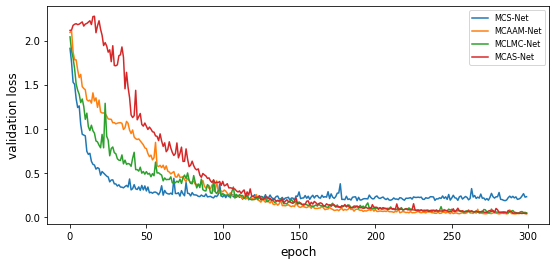

In [148]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(history_model.history['val_loss'])
plt.plot(history_arc.history['val_loss'])
plt.plot(history_cos.history['val_loss'])
plt.plot(history_sphere.history['val_loss'])
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['MCS-Net', 'MCAAM-Net','MCLMC-Net','MCAS-Net'], loc='upper right')
plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

### Visualization of the Softmax-CNN, Arc-CNN, Cos-CNN, Sphere-CNN

#### This Section contains the loading the model with the saved weights. 
* Please check the Test accuracy values from here (it matches with the table in the paper)
* The embedded feature diagram are generated using the models loaded with saved weights 

#### Softmax-CNN

In [243]:
model.load_weights("C:/Users/pc/Desktop/Journal/Best Weights/MFCC_STFT/model.hdf5")

In [244]:
# Test score using the best weights for the validation
train_score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy {:.3f}%".format(train_score[1]*100))
test_score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy {:.3f}%".format(test_score[1]*100))

Training Accuracy 99.785%
Testing Accuracy 95.707%


In [245]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 5, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 5, 64)         1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 3, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 2, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 2, 128)        

In [246]:
model.input

<tf.Tensor 'input_1:0' shape=(None, 20, 5, 1) dtype=float32>

In [247]:
#making an intermediate model to extract the embedded features 
model_inter = Model(inputs=model.input, outputs=model.layers[-2].output)
embedded_features = model_inter.predict(x_test, verbose=1)
embedded_features /= np.linalg.norm(embedded_features, axis=1, keepdims=True)

55/55 [==============================] - 1s 15ms/step


In [248]:
from sklearn.decomposition import PCA
pca_CNN = PCA(n_components=2)

In [249]:
pcas= pca_CNN.fit_transform(embedded_features)

In [250]:
print("Information in PCA 1: {:.3f}%".format(pca_CNN.explained_variance_ratio_[0]*100))
print("Information in PCA 2: {:.3f}%".format(pca_CNN.explained_variance_ratio_[1]*100))
print("The amount of information after dimension reduction: {:.3f}%".format(sum(pca_CNN.explained_variance_ratio_)*100))
print("The amount of information lost: {:.3f}%".format(100 - sum(pca_CNN.explained_variance_ratio_)*100 ))

Information in PCA 1: 15.190%
Information in PCA 2: 10.767%
The amount of information after dimension reduction: 25.956%
The amount of information lost: 74.044%


In [251]:
cnn_df = pd.DataFrame(pcas, columns=["pca1", "pca2"])
cnn_df["label"]=np.argmax(y_test, axis=1)
cnn_df.head()

,pca1,pca2,label
0,-0.179573,-0.307494,4
1,0.183762,-0.026962,0
2,-0.480710,-0.014556,3
3,-0.099783,-0.283667,9
4,-0.422247,-0.028971,3


In [253]:
%run utils.ipynb

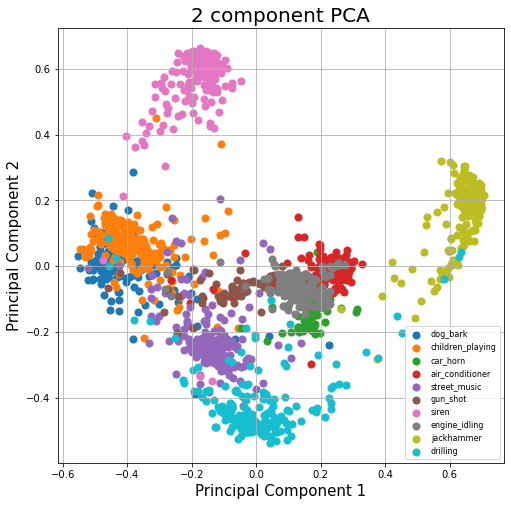

In [254]:
plot_embedded_smaller(cnn_df, 200)

#### Arc-CNN 

In [255]:
model_arc.load_weights("C:/Users/pc/Desktop/Journal/Best Weights/MFCC_STFT/arc.hdf5")

In [256]:
#Test score using the best weights for validation 
train_score = model_arc.evaluate([x_train, y_train], y_train, verbose=0)
print("Training Accuracy {:.3f}%".format(train_score[1]*100))

test_score = model_arc.evaluate([x_test, y_test], y_test, verbose=0)
print("Testing Accuracy {:.3f}%".format(test_score[1]*100))

Training Accuracy 99.943%
Testing Accuracy 99.599%


In [257]:
modelArc_inter = Model(inputs=model_arc.input[0], outputs=model_arc.layers[-5].output)
Arc_embedded_features = modelArc_inter.predict(x_test, verbose=1)
Arc_embedded_features /= np.linalg.norm(Arc_embedded_features, axis=1, keepdims=True)

55/55 [==============================] - 1s 15ms/step


In [258]:
print(Arc_embedded_features.shape)

(1747, 512)


In [259]:
#Dimensionality reduction using PCA for the visualization of the data 
from sklearn.decomposition import PCA
pca_arc=PCA(n_components=2)

In [260]:
pcas= pca_arc.fit_transform(Arc_embedded_features)

In [261]:
print("Information in PCA 1: {:.3f}%".format(pca_arc.explained_variance_ratio_[0]*100))
print("Information in PCA 2: {:.3f}%".format(pca_arc.explained_variance_ratio_[1]*100))
print("The amount of information after dimension reduction: {:.3f}%".format(sum(pca_arc.explained_variance_ratio_)*100))
print("The amount of information lost: {:.3f}%".format(100 - sum(pca_arc.explained_variance_ratio_)*100 ))

Information in PCA 1: 34.798%
Information in PCA 2: 24.381%
The amount of information after dimension reduction: 59.178%
The amount of information lost: 40.822%


In [262]:
Arc_df = pd.DataFrame(data = pcas , columns=["pca1", "pca2"])
Arc_df["label"] = np.argmax(y_test, axis=1)
Arc_df.head()

,pca1,pca2,label
0,0.179442,0.258401,4
1,-0.469962,0.140053,0
2,0.643930,-0.074480,3
3,-0.360818,0.595998,9
4,0.649449,-0.118733,3


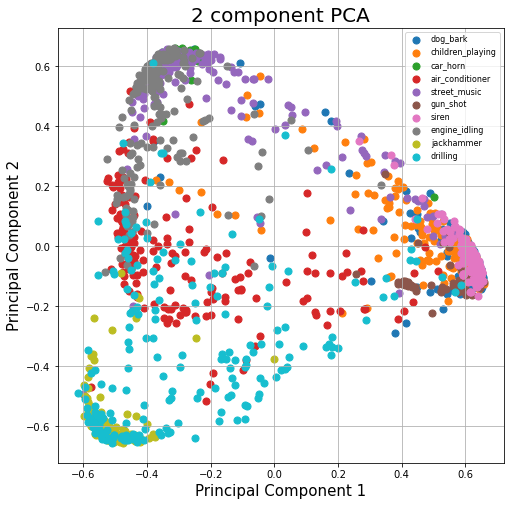

In [263]:
plot_embedded_smaller(Arc_df, 200)

#### Cos-CNN

In [264]:
model_cos.load_weights("C:/Users/pc/Desktop/Journal/Best Weights/MFCC_STFT/cos.hdf5")

In [265]:
#Test score using the best weights for validation 
train_score = model_cos.evaluate([x_train, y_train], y_train, verbose=0)
print("Training Accuracy {:.3f}%".format(train_score[1]*100))

test_score = model_cos.evaluate([x_test, y_test], y_test, verbose=0)
print("Testing Accuracy {:.3f}%".format(test_score[1]*100))

Training Accuracy 100.000%
Testing Accuracy 99.370%


In [266]:
model_cos.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 5, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 20, 5, 64)    1664        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 10, 3, 64)    0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 10, 3, 128)   204928      max_pooling2d_4[0][0]            
_______________________________________________________________________________________

In [267]:
modelCos_inter = Model(inputs=model_cos.input[0], outputs=model_cos.layers[-5].output)
Cos_embedded_features = modelCos_inter.predict(x_test, verbose=1)
Cos_embedded_features /= np.linalg.norm(Cos_embedded_features, axis=1, keepdims=True)

55/55 [==============================] - 1s 14ms/step


In [268]:
Cos_embedded_features.shape

(1747, 512)

In [269]:
#Dimensionality reduction using PCA for the visualization of the data 
from sklearn.decomposition import PCA
pca_cos=PCA(n_components=2)

In [270]:
pcas = pca_cos.fit_transform(Cos_embedded_features)

In [271]:
print("Information in PCA 1: {:.3f}%".format(pca_cos.explained_variance_ratio_[0]*100))
print("Information in PCA 2: {:.3f}%".format(pca_cos.explained_variance_ratio_[1]*100))
print("The amount of information after dimension reduction: {:.3f}%".format(sum(pca_cos.explained_variance_ratio_)*100))
print("The amount of information lost: {:.3f}%".format(100 - sum(pca_cos.explained_variance_ratio_)*100 ))

Information in PCA 1: 34.680%
Information in PCA 2: 16.615%
The amount of information after dimension reduction: 51.294%
The amount of information lost: 48.706%


In [272]:
Cos_df = pd.DataFrame(data = pcas, columns=["pca1", "pca2"])
Cos_df["label"] = np.argmax(y_test, axis=1)
Cos_df.head()

,pca1,pca2,label
0,-0.610649,-0.154314,4
1,0.322915,0.659926,0
2,-0.555684,-0.095567,3
3,-0.342049,-0.218240,9
4,-0.543606,-0.071229,3


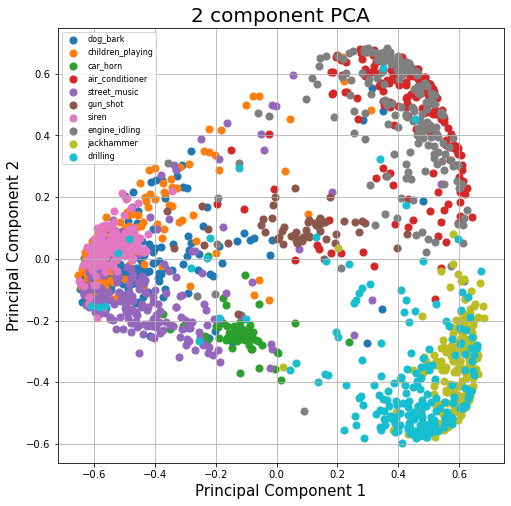

In [274]:
plot_embedded_smaller(Cos_df, 200)

#### SphereCNN

In [275]:
model_sphere.load_weights("C:/Users/pc/Desktop/Journal/Best Weights/MFCC_STFT/sphere.hdf5")

In [276]:
#Test score using the best weights for validation 
train_score = model_sphere.evaluate([x_train, y_train], y_train, verbose=0)
print("Training Accuracy {:.3f}%".format(train_score[1]*100))

test_score = model_sphere.evaluate([x_test, y_test], y_test, verbose=0)
print("Testing Accuracy {:.3f}%".format(test_score[1]*100))

Training Accuracy 99.971%
Testing Accuracy 99.428%


In [277]:
modelSphere_inter = Model(inputs=model_sphere.input[0], outputs=model_sphere.layers[-5].output)
Sphere_embedded_features = modelSphere_inter.predict(x_test, verbose=1)
Sphere_embedded_features /= np.linalg.norm(Sphere_embedded_features, axis=1, keepdims=True)

55/55 [==============================] - 2s 39ms/step


In [278]:
print(Sphere_embedded_features.shape)

(1747, 512)


In [279]:
pca_sphere = PCA(n_components=2)

In [280]:
pcas = pca_sphere.fit_transform(Sphere_embedded_features)

In [281]:
print("Information in PCA 1: {:.3f}%".format(pca_sphere.explained_variance_ratio_[0]*100))
print("Information in PCA 2: {:.3f}%".format(pca_sphere.explained_variance_ratio_[1]*100))
print("The amount of information after dimension reduction: {:.3f}%".format(sum(pca_sphere.explained_variance_ratio_)*100))
print("The amount of information lost: {:.3f}%".format(100 - sum(pca_sphere.explained_variance_ratio_)*100 ))

Information in PCA 1: 43.511%
Information in PCA 2: 19.423%
The amount of information after dimension reduction: 62.934%
The amount of information lost: 37.066%


In [282]:
sphere_df = pd.DataFrame(pcas, columns=["pca1", "pca2"])
sphere_df["label"] = np.argmax(y_test, axis=1)
sphere_df.head()

,pca1,pca2,label
0,0.222325,-0.233966,4
1,-0.486041,-0.388320,0
2,0.738926,-0.016358,3
3,-0.370314,-0.059528,9
4,0.665370,-0.076047,3


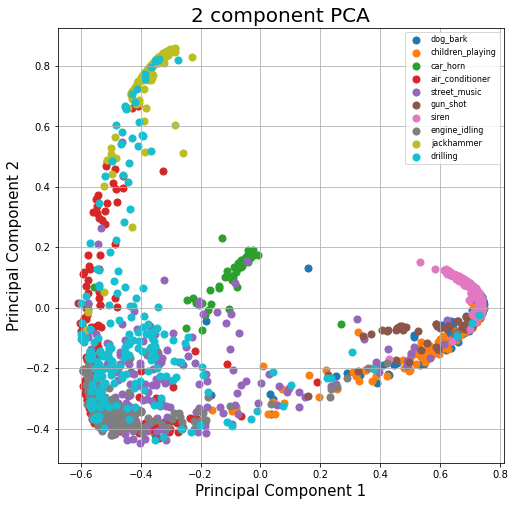

In [315]:
plot_embedded_smaller(sphere_df, 200)
plt.savefig('ajaira.png')

### The Confusion matrix of MCAAM-Net 

In [285]:
Class_Label = {'Air_conditioner':0, 'Car_horn':1, 'Children_playing':2, 'Dog_Bark':3, 
               'Drilling':4,'Engine_idling':5, 'Gun_Shot' :6, 'Jackhammer': 7 ,'Siren':8,'Street_Music':9 }

In [286]:
y_true = np.argmax(y_test, axis = 1)
y_pred = model_arc.predict([x_test, y_test])
y_pred = np.argmax(y_pred, axis=1)

In [287]:
SMALL_SIZE = 15
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [316]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

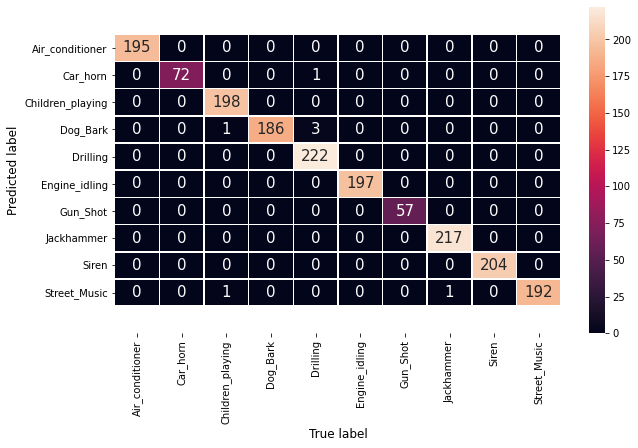

In [331]:
mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(mat, square=False, annot=True, fmt='d',cbar=True,linewidths=.5,xticklabels=Class_Label.keys(),yticklabels=Class_Label.keys(), cmap='rocket')
bottom, top= ax.get_ylim()
plt.ylim(bottom + 0.5 , top -0.5)
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.savefig("confusion_mat(ori).pdf", bbox_inches="tight", dpi=100)

In [326]:
fig.show()

<ipython-input-326-6ebedab27258>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [321]:
plt.savefig("confusionlt.png", bbox_inches='tight', dpi = 100)

<Figure size 432x288 with 0 Axes>

In [335]:
def plot_embedded_upgrade(dataframe, points_plotted=50):
    fig_em, axs = plt.subplots(2, 2, figsize=(15,15))
    #axs.set_xlabel('Principal Component 1', fontsize = 15)
    #axs.set_ylabel('Principal Component 2', fontsize = 15)
    #axs.set_title('2 component PCA', fontsize = 20)
    targets = [3, 2, 1, 0, 9, 6, 8, 5, 7, 4]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    for target, color in zip(targets,colors):
        indicesToKeep = dataframe[0]['label'] == target
            #print(indicesToKeep)
        axs[0,0].scatter(list(dataframe[0].loc[indicesToKeep, 'pca1'])[:points_plotted]
                       ,list(dataframe[0].loc[indicesToKeep, 'pca2'])[:points_plotted]
                       , c = color
                       , s = 30)
        axs[0,0].legend(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
           'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
           'drilling'])
        axs[0,0].set_xlabel('Principal Component 1')
        axs[0,0].set_ylabel('Principal Component 2')
        axs[0,0].set_title("MCS-Net", fontsize = 15)
        axs[0,0].grid()
        axs[0,1].scatter(list(dataframe[1].loc[indicesToKeep, 'pca1'])[:points_plotted]
                       ,list(dataframe[1].loc[indicesToKeep, 'pca2'])[:points_plotted]
                       , c = color
                       , s = 30)
        axs[0,1].legend(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
           'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
           'drilling'])
        axs[0,1].set_xlabel('Principal Component 1')
        axs[0,1].set_ylabel('Principal Component 2')
        axs[0,1].set_title("MCAAM-Net", fontsize = 15)
        axs[0,1].grid()
        axs[1,0].scatter(list(dataframe[2].loc[indicesToKeep, 'pca1'])[:points_plotted]
                       ,list(dataframe[2].loc[indicesToKeep, 'pca2'])[:points_plotted]
                       , c = color
                       , s = 30)
        axs[1,0].legend(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
           'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
           'drilling'])
        axs[1,0].set_xlabel('Principal Component 1')
        axs[1,0].set_ylabel('Principal Component 2')
        axs[1,0].set_title("MCLMC-Net", fontsize = 15)
        axs[1,0].grid()
        axs[1,1].scatter(list(dataframe[3].loc[indicesToKeep, 'pca1'])[:points_plotted]
                       ,list(dataframe[3].loc[indicesToKeep, 'pca2'])[:points_plotted]
                       , c = color
                       , s = 30)
        axs[1,1].legend(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
           'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
           'drilling'])
        axs[1,1].set_xlabel('Principal Component 1')
        axs[1,1].set_ylabel('Principal Component 2')
        axs[1,1].set_title("MCAS-Net", fontsize = 15)
        axs[1,1].grid()
        
    fig_em.savefig("embedding.pdf", bbox_inches='tight', dpi=1000)

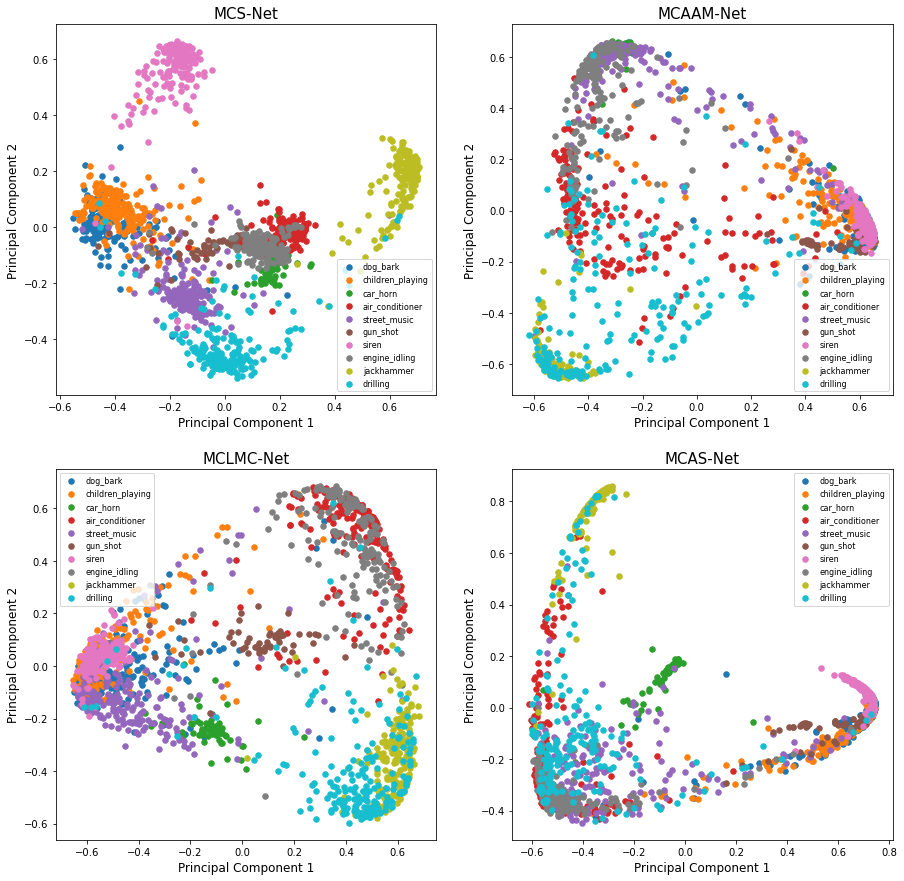

In [336]:
plot_embedded_upgrade([cnn_df,Arc_df,Cos_df, sphere_df], 200)